In [1]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sklearn
from scipy import linalg, signal, optimize
import lockin
import phasekick2 as pk2
import phasekick as pk
import tqdm
import sigutils
import munch
from timedomainfit import *
import timedomainfit as td

def print_popt(x, cov=None, print_string=True):
    names = ["f_i = {:8.1f}{}Hz",
             " df = {:8.1f}{}Hz",
             "f_f = {:8.1f}{}Hz",
             " X0 = {:8.1f}{}nm",
             " Y0 = {:8.1f}{}nm",
            u" τ1 = {:8.1f}{}µs",
            u" τ2 = {:8.1f}{}µs",
            u"  r = {:8.2f}{}",
             " Q0 = {:8.0f}{}",
             "Qhv = {:8.0f}{}",
            u" Δx = {:8.2f}{}nm"
            ]
    scales = [1, 1, 1, 1, 1, 1e6, 1e6, 1, 1, 1, 1]
    string = []
    if cov is None:
        covs = [" " for i in x]

    for n, name, cov, scale in zip(x, names, covs, scales):
        string.append(name.format(n*scale, cov))
    string = "\n".join(string)
    if print_string:
        print(string)
    return string

def plot_lis(lis, y):
    fig, ax = plt.subplots()
    for li in lis:
        ax.plot(li('t'), li(y), label=li.name)
    
    return fig, ax

In [2]:
fs = 1e6
ba = signal.butter(2, np.array([1e3, 200e3]) / (fs/2), analog=False, btype='bandpass')

In [3]:
phit, optfunc, optfuncQ, optfuncDC, optfuncDet, xDCt, xDC_all = td.make_optfunc(t0=0, tp=1.4e-3)

In [4]:
fh = h5py.File("../../data/tr-efm/151218-003450-100sun-784.h5", "r")
params =   {'fp': 4000,
             'fc': 15000,
             't_phase': -0.052,
             'ti': -54e-3,
             'tf': 6e-3,
             'Ndec': 1}
fir = lockin.lock2(66000, params['fp'], params['fc'], fs=1e6)

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
33000.000 0.000 -110.366
66000.000 0.000 -141.187
500000.000 0.000 -196.320


In [5]:
b = td.signal_average_gr(fh['data'], -1.5e-3, 1.4e-3)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3091.594 0.983   -0.152
 6183.187 0.927   -0.658
24732.750 0.095  -20.422
30915.937 0.011  -38.973
49465.500 0.000 -101.894
61831.875 0.000 -110.805
500000.000 0.000 -335.211


In [6]:
simp, simp2, simpDC = td.make_simple_opt(0.0, 1.5e-3, 30000,
                                         62e3, 1e2, 200e3, 1e6)

In [7]:
p0simp = np.array([61850.0, -30.0, 62000.0, 0.0, 0.0, 0.5e-3])
b.simp = td.fit(simp, b.t, b.x, p0=p0simp)

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Response:
f   mag       dB
    0.000 1.000    0.000
 3091.607 0.983   -0.152
 6183.214 0.927   -0.658
24732.857 0.095  -20.422
30916.071 0.011  -38.973
49465.714 0.000 -101.894
61832.142 0.000 -110.804
500000.000 0.000 -340.476


In [8]:
p0simp2 = np.r_[b.simp.popt[:-1], [0.1e-3, 1e-3, 0.5]]
b.simp2 = td.fit(simp2, b.t, b.x, p0=p0simp2)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3091.593 0.983   -0.152
 6183.186 0.927   -0.658
24732.742 0.095  -20.422
30915.928 0.011  -38.973
49465.485 0.000 -101.894
61831.856 0.000 -110.805
500000.000 0.000 -337.305


In [9]:
b.simp2.popt

array([  6.18406118e+04,  -4.01709611e+01,   6.20000000e+04,
        -3.06063983e+01,  -2.60690501e+01,   1.90601460e-05,
         4.16560906e-04,   2.50476648e-01])

In [10]:
p0simpDC = np.array([  6.18406118e+04,  -4.01709611e+01,   6.20000000e+04,
        -38.063983e+00,  -1.30690501e+01,   1.90601460e-05,
         4.16560906e-04,   2.50476648e-01, 40000, 10000, 1.0])
p1simpDC = np.array([  6.18405388e+04,  -3.97535568e+01,   2.57538438e+04,
        -3.86519265e+01,  -1.26430869e+01,   5.38825741e-05,
         4.00669831e-04,   2.56587152e-01,   4.12554789e+04,
         1.08288224e+04,   1.22577851e+00])
b.simpDC = td.fit(simpDC, b.t, b.x5, p0=p1simpDC, name='simpDC',
                  tfit=b.t5)

Response:
f   mag       dB
    0.000 1.000   -0.000
 3091.182 0.983   -0.152
 6182.365 0.927   -0.658
24729.458 0.095  -20.420
30911.823 0.011  -38.968
49458.916 0.000 -101.897
61823.645 0.000 -110.811
500000.000 0.000 -336.639


In [11]:
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

([<matplotlib.axis.XTick at 0x11814a110>,
 <a list of 6 Text xticklabel objects>)

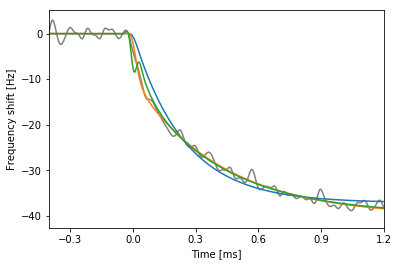

In [12]:
colors=['0.5']
colors.extend(color_cycle)

for li, color in zip([b.li, b.simp.li, b.simp2.li, b.simpDC.li], colors) :
    plt.plot(li('t')*1e3, li('df'), color=color)

plt.ylabel("Frequency shift [Hz]")
plt.xlabel("Time [ms]")
plt.xlim(-0.4, 1.2)
plt.xticks(np.linspace(-0.3, 1.2, 6))
# plt.savefig("../../../../Talks/161109-pk-efm-theory-v2/df-time-domain.pdf")

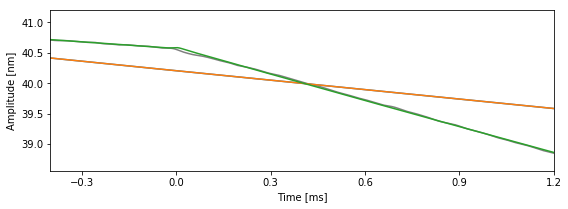

In [13]:

fig = plt.figure(figsize=(8, 3))
for li, color in zip([b.li, b.simp.li, b.simp2.li, b.simpDC.li], colors) :
    plt.plot(li('t')*1e3, li('A'), color=color)

plt.ylabel("Amplitude [nm]")
plt.xlabel("Time [ms]")
plt.xlim(-0.4, 1.2)
plt.xticks(np.linspace(-0.3, 1.2, 6))
fig.tight_layout()
# fig.savefig("../../../../Talks/161109-pk-efm-theory-v2/A-time-domain.pdf", bbox_inches='tight', transparent=True)

(<matplotlib.figure.Figure at 0x1184b1ad0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11839fe50>)

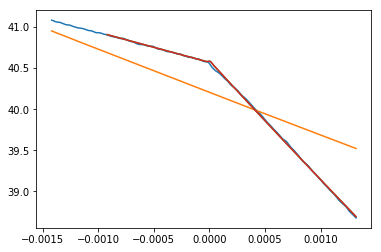

In [14]:
plot_lis([b.li, b.simp.li, b.simpDC.li, b.simpDC.li], 'A')

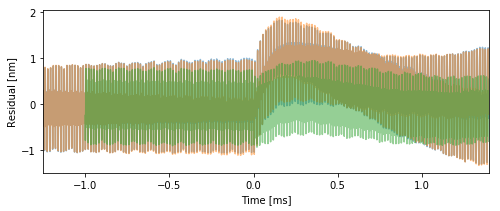

In [15]:
fig = plt.figure(figsize=(8, 3))
fits = [b.simp, b.simp2, b.simpDC]
ts = [b.t, b.t, b.t5]
for t, fit in zip(ts, fits):
    plt.plot(t*1e3, fit.resid, label=fit.name, alpha=0.5,)

plt.xlim(-1.25, 1.4)
plt.ylabel("Residual [nm]")
plt.xlabel("Time [ms]")
# fig.savefig("../../../../Talks/161109-pk-efm-theory-v2/residual-time-domain.pdf", bbox_inches='tight', transparent=True)

In [16]:
print_popt(b.simpDC.popt);

f_i =  61840.6 Hz
 df =    -39.8 Hz
f_f =  21703.0 Hz
 X0 =    -38.7 nm
 Y0 =    -12.6 nm
 τ1 =     52.5 µs
 τ2 =    401.3 µs
  r =     0.26 
 Q0 =    43340 
Qhv =    10733 
 Δx =     1.16 nm
